
# 🤖 03_Modeling — Побудова та оцінка моделей ML
**Project:** Прогнозування Відтоку Клієнтів  
**Author:**   
**Team Lead:** Vitalii Subbotin  
**Date:** 2025-10-09
---


In [1]:
# 1. Імпорт бібліотек і налаштування середовища
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

import time
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    RocCurveDisplay
)
import joblib

# Моделі scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# опціонально — підключаємо бустери, якщо встановлені
try:
    from xgboost import XGBClassifier
    xgb_available = True
except Exception:
    XGBClassifier = None
    xgb_available = False

try:
    from lightgbm import LGBMClassifier
    lgb_available = True
except Exception:
    LGBMClassifier = None
    lgb_available = False

try:
    from catboost import CatBoostClassifier
    cat_available = True
except Exception:
    CatBoostClassifier = None
    cat_available = False

print("Пакети: XGBoost:", xgb_available, "LightGBM:", lgb_available, "CatBoost:", cat_available)


Пакети: XGBoost: True LightGBM: True CatBoost: True


In [2]:
# 2. Налаштування шляхів і констант
BASE_DIR = Path("..")             # змініть при необхідності
DATA_DIR = BASE_DIR / "data"
MODELS_DIR = BASE_DIR / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

DATA_PATH = DATA_DIR / "df1_mean.csv"   # перевірте, що файл тут
RANDOM_STATE = 42
CV_FOLDS = 5

print("DATA_PATH ->", DATA_PATH)


DATA_PATH -> ..\data\df1_mean.csv


In [3]:
# 3. Завантаження даних
df = pd.read_csv(DATA_PATH)
print("Розмір датасету:", df.shape)
display(df.head())

print("\nПропуски по стовпцях:")
display(df.isnull().sum())

# Видаляємо id (не фіча)
if 'id' in df.columns:
    print("Видаляємо колонку 'id'")
    df = df.drop(columns=['id'])

# Гарантуємо, що мета називається 'churn'
if 'churn' not in df.columns and 'Churn' in df.columns:
    df.rename(columns={'Churn': 'churn'}, inplace=True)
assert 'churn' in df.columns, "В датасеті має бути стовпець 'churn'"

print("\nРозподіл класів (churn):")
display(df['churn'].value_counts())

Розмір датасету: (71893, 12)


,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn,reamining_contract_missing
0,15,1,0,11.95,25,0.140000,0,8.4,2.3,0,0,0
1,18,0,0,8.22,0,0.710171,0,0.0,0.0,0,1,1
2,23,1,0,8.91,16,0.000000,0,13.7,0.9,0,1,0
3,27,0,0,6.87,21,0.710171,1,0.0,0.0,0,1,1
4,34,0,0,6.39,0,0.710171,0,0.0,0.0,0,1,1



Пропуски по стовпцях:


id                             0
is_tv_subscriber               0
is_movie_package_subscriber    0
subscription_age               0
bill_avg                       0
reamining_contract             0
service_failure_count          0
download_avg                   0
upload_avg                     0
download_over_limit            0
churn                          0
reamining_contract_missing     0
dtype: int64

Видаляємо колонку 'id'

Розподіл класів (churn):


churn
1    40050
0    31843
Name: count, dtype: int64

In [4]:
# 4. Перевірка кореляцій з целевою для виявлення підозрілих фіч
corrs = df.corr()['churn'].abs().sort_values(ascending=False)
print("Топ корельованих ознак з churn:")
display(corrs.head(15))

Топ корельованих ознак з churn:


churn                          1.000000
reamining_contract             0.516500
reamining_contract_missing     0.472771
is_tv_subscriber               0.329417
is_movie_package_subscriber    0.307789
download_avg                   0.298063
upload_avg                     0.162690
download_over_limit            0.157626
subscription_age               0.126672
bill_avg                       0.027550
service_failure_count          0.019680
Name: churn, dtype: float64

In [5]:
# 5. Формуємо X, y і розбиваємо на train/test
X = df.drop(columns=['churn'])
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (57514, 10) Test shape: (14379, 10)


In [6]:
# 6. Масштабування — не масштабувати бінарні колонки
binary_cols = [c for c in X_train.columns if X_train[c].nunique() <= 2]
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
numeric_to_scale = [c for c in numeric_cols if c not in binary_cols]

print("Бінарні колонки (не масштабуються):", binary_cols)
print("Числові колонки для масштабування:", numeric_to_scale)

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_to_scale] = scaler.fit_transform(X_train[numeric_to_scale])
X_test_scaled[numeric_to_scale] = scaler.transform(X_test[numeric_to_scale])

# Збережемо scaler
joblib.dump(scaler, MODELS_DIR / "scaler.pkl")
print("✅ Scaler збережено у:", MODELS_DIR / "scaler.pkl")

Бінарні колонки (не масштабуються): ['is_tv_subscriber', 'is_movie_package_subscriber', 'reamining_contract_missing']
Числові колонки для масштабування: ['subscription_age', 'bill_avg', 'reamining_contract', 'service_failure_count', 'download_avg', 'upload_avg', 'download_over_limit']
✅ Scaler збережено у: ..\models\scaler.pkl


In [7]:
# 7. Функція evaluate_model
def evaluate_model(name, model, X_tr, y_tr, X_te, y_te, fit_kwargs=None):
    fit_kwargs = fit_kwargs or {}
    t0 = time.time()
    # Навчання (якщо модель підтримує додаткові fit_kwargs)
    if fit_kwargs:
        model.fit(X_tr, y_tr, **fit_kwargs)
    else:
        model.fit(X_tr, y_tr)
    dur = time.time() - t0

    # Прогноз і ймовірності
    y_pred = model.predict(X_te)
    y_proba = None
    if hasattr(model, "predict_proba"):
        try:
            y_proba = model.predict_proba(X_te)[:, 1]
        except Exception:
            y_proba = None
    elif hasattr(model, "decision_function"):
        try:
            y_proba = model.decision_function(X_te)
        except Exception:
            y_proba = None

    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, zero_division=0)
    rec = recall_score(y_te, y_pred, zero_division=0)
    f1 = f1_score(y_te, y_pred, zero_division=0)
    roc = roc_auc_score(y_te, y_proba) if y_proba is not None else np.nan

    print(f"\n--- {name} ---")
    print(f"train_time: {dur:.2f}s | Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, ROC-AUC: {roc:.4f}")

    return {
        "model_name": name,
        "model_obj": model,
        "train_time_s": dur,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc,
        "y_pred": y_pred,
        "y_proba": y_proba
    }

In [8]:
# 8. Підготовка моделей (опціонально підключаємо бустери)
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=200, n_jobs=4, random_state=RANDOM_STATE),
    "SVC_linear": SVC(kernel='linear', probability=True, random_state=RANDOM_STATE),
    "MLP": MLPClassifier(hidden_layer_sizes=(128,64), max_iter=300, random_state=RANDOM_STATE),
    "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE)
}

if xgb_available:
    models["XGBoost"] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=200, random_state=RANDOM_STATE, verbosity=0)
else:
    print("⚠️ XGBoost не встановлено — пропускаємо")

if lgb_available:
    # force_row_wise та verbose=-1 щоб мінімізувати повідомлення
    models["LightGBM"] = LGBMClassifier(n_estimators=200, n_jobs=4, force_row_wise=True, verbose=-1, random_state=RANDOM_STATE)
else:
    print("⚠️ LightGBM не встановлено — пропускаємо")

if cat_available:
    models["CatBoost"] = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.05, random_seed=RANDOM_STATE, verbose=False)
else:
    print("⚠️ CatBoost не встановлено — пропускаємо")

print("Will run:", list(models.keys()))

Will run: ['LogisticRegression', 'RandomForest', 'SVC_linear', 'MLP', 'GradientBoosting', 'XGBoost', 'LightGBM', 'CatBoost']


In [9]:
# 9. CV (StratifiedKFold) для оцінки стабільності (ROC-AUC)
cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
cv_results = []
for name, mdl in models.items():
    try:
        print(f"\nCV for {name} ...")
        scores = cross_val_score(mdl, X_train_scaled, y_train, cv=cv, scoring='roc_auc', n_jobs=4)
        cv_results.append({"model": name, "cv_mean_auc": float(scores.mean()), "cv_std_auc": float(scores.std())})
        print(f"  CV ROC-AUC: {scores.mean():.4f} ± {scores.std():.4f}")
    except Exception as e:
        print(f"  ⚠️ CV failed for {name}: {e}")

cv_df = pd.DataFrame(cv_results).sort_values(by="cv_mean_auc", ascending=False).reset_index(drop=True)
display(cv_df)


CV for LogisticRegression ...
  CV ROC-AUC: 0.9329 ± 0.0018

CV for RandomForest ...
  CV ROC-AUC: 0.9807 ± 0.0008

CV for SVC_linear ...
  CV ROC-AUC: 0.9346 ± 0.0021

CV for MLP ...
  CV ROC-AUC: 0.9707 ± 0.0014

CV for GradientBoosting ...
  CV ROC-AUC: 0.9737 ± 0.0019

CV for XGBoost ...
  CV ROC-AUC: 0.9810 ± 0.0011

CV for LightGBM ...
  CV ROC-AUC: 0.9819 ± 0.0017

CV for CatBoost ...
  CV ROC-AUC: nan ± nan


,model,cv_mean_auc,cv_std_auc
0,LightGBM,0.981903,0.001724
1,XGBoost,0.981013,0.001108
2,RandomForest,0.980667,0.000753
3,GradientBoosting,0.973661,0.001904
4,MLP,0.970666,0.001425
5,SVC_linear,0.934585,0.002133
6,LogisticRegression,0.932874,0.001753
7,CatBoost,NaN,NaN


In [10]:
# 10. Навчання на усьому train та оцінка на test (early stopping для XGBoost/CatBoost)
results = []
for name, mdl in models.items():
    fit_kwargs = {}
    if name == "XGBoost" and xgb_available:
        fit_kwargs = {"eval_set": [(X_test_scaled, y_test)], "early_stopping_rounds": 30, "verbose": False}
    if name == "CatBoost" and cat_available:
        fit_kwargs = {"eval_set": (X_test_scaled, y_test), "early_stopping_rounds": 50, "verbose": False}

    try:
        res = evaluate_model(name, mdl, X_train_scaled, y_train, X_test_scaled, y_test, fit_kwargs=fit_kwargs)
        results.append(res)
    except Exception as e:
        print(f"Не вдалося навчити/оценити модель {name}: {e}")


--- LogisticRegression ---
train_time: 0.13s | Accuracy: 0.8781, Precision: 0.8781, Recall: 0.9071, F1: 0.8924, ROC-AUC: 0.9343

--- RandomForest ---
train_time: 16.11s | Accuracy: 0.9430, Precision: 0.9601, Recall: 0.9366, F1: 0.9482, ROC-AUC: 0.9824

--- SVC_linear ---
train_time: 1201.85s | Accuracy: 0.8814, Precision: 0.8758, Recall: 0.9171, F1: 0.8960, ROC-AUC: 0.9356

--- MLP ---
train_time: 3348.95s | Accuracy: 0.9372, Precision: 0.9559, Recall: 0.9302, F1: 0.9429, ROC-AUC: 0.9741

--- GradientBoosting ---
train_time: 14.46s | Accuracy: 0.9398, Precision: 0.9603, Recall: 0.9303, F1: 0.9451, ROC-AUC: 0.9744
Не вдалося навчити/оценити модель XGBoost: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

--- LightGBM ---
train_time: 1.25s | Accuracy: 0.9470, Precision: 0.9618, Recall: 0.9423, F1: 0.9519, ROC-AUC: 0.9831

--- CatBoost ---
train_time: 38.67s | Accuracy: 0.9437, Precision: 0.9611, Recall: 0.9370, F1: 0.9489, ROC-AUC: 0.9821


In [11]:
# 11. Summary і збереження
summary = pd.DataFrame([{
    "model": r["model_name"],
    "train_time_s": r["train_time_s"],
    "accuracy": r["accuracy"],
    "precision": r["precision"],
    "recall": r["recall"],
    "f1": r["f1"],
    "roc_auc": r["roc_auc"]
} for r in results]).sort_values(by="roc_auc", ascending=False).reset_index(drop=True)

print("📊 Зведена таблиця результатів:")
display(summary)

# збереження
summary.to_csv(MODELS_DIR / "models_comparison_summary.csv", index=False)
print("✅ Summary збережено у:", MODELS_DIR / "models_comparison_summary.csv")

📊 Зведена таблиця результатів:


,model,train_time_s,accuracy,precision,recall,f1,roc_auc
0,LightGBM,1.249593,0.947006,0.961774,0.942322,0.951949,0.983117
1,RandomForest,16.105638,0.942972,0.960072,0.936579,0.948180,0.982438
2,CatBoost,38.673756,0.943737,0.961071,0.936954,0.948859,0.982132
3,GradientBoosting,14.455957,0.939773,0.960309,0.930337,0.945086,0.974365
4,MLP,3348.949078,0.937200,0.955869,0.930212,0.942866,0.974107
5,SVC_linear,1201.853839,0.881355,0.875775,0.917104,0.895963,0.935634
6,LogisticRegression,0.133576,0.878086,0.878066,0.907116,0.892355,0.934264


✅ Summary збережено у: ..\models\models_comparison_summary.csv


<Figure size 800x600 with 0 Axes>

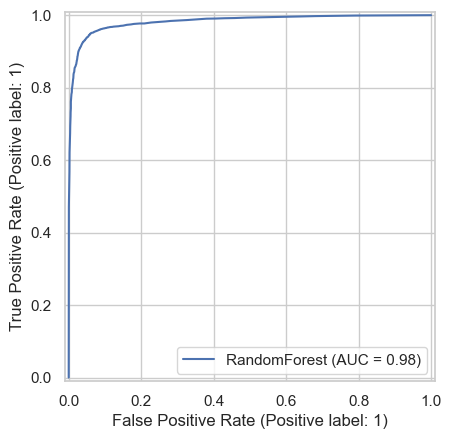

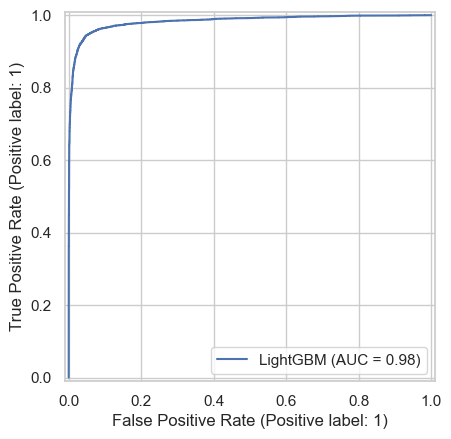

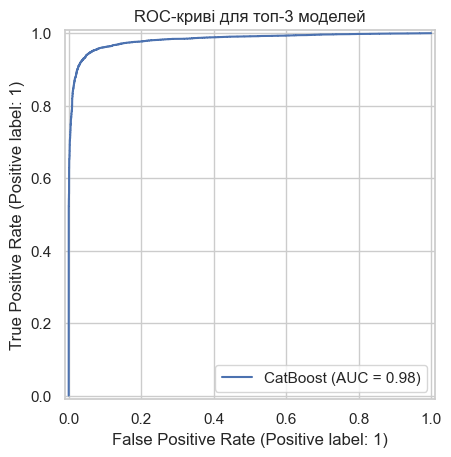

In [12]:
# 12. ROC для топ-3 моделей (за roc_auc)
top3 = summary['model'].head(3).tolist()
plt.figure(figsize=(8,6))
for r in results:
    if r['model_name'] in top3 and r['y_proba'] is not None:
        RocCurveDisplay.from_predictions(y_test, r['y_proba'], name=r['model_name'])
plt.title('ROC-криві для топ-3 моделей')
plt.show()

In [13]:
# 13. Збереження найкращої моделі за roc_auc
if not summary.empty:
    best_row = summary.iloc[0]
    best_model_name = best_row['model']
    best_obj = next((r['model_obj'] for r in results if r['model_name'] == best_model_name), None)
    if best_obj is not None:
        model_path = MODELS_DIR / f"best_model_{best_model_name}.pkl"
        joblib.dump(best_obj, model_path)
        print("✅ Найкраща модель збережена у:", model_path)
        # scaler вже збережено раніше
    else:
        print("⚠️ Не вдалося знайти об'єкт найкращої моделі для збереження.")
else:
    print("⚠️ Summary порожній — модель не збережено.")

✅ Найкраща модель збережена у: ..\models\best_model_LightGBM.pkl


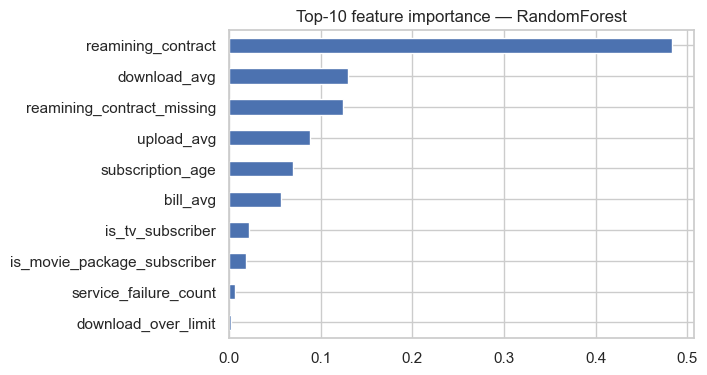

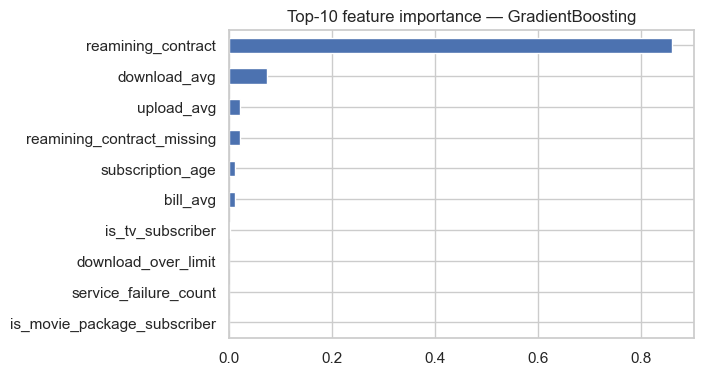

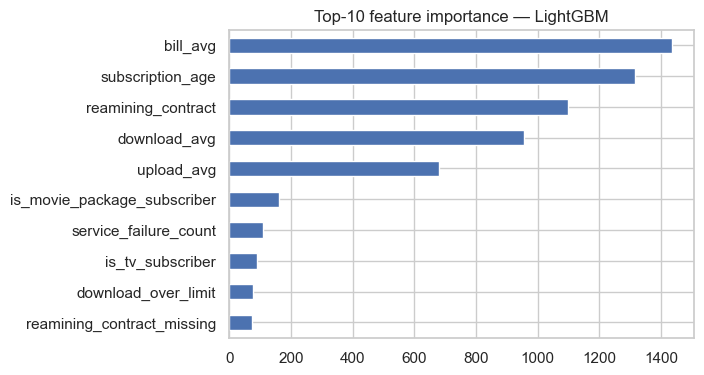

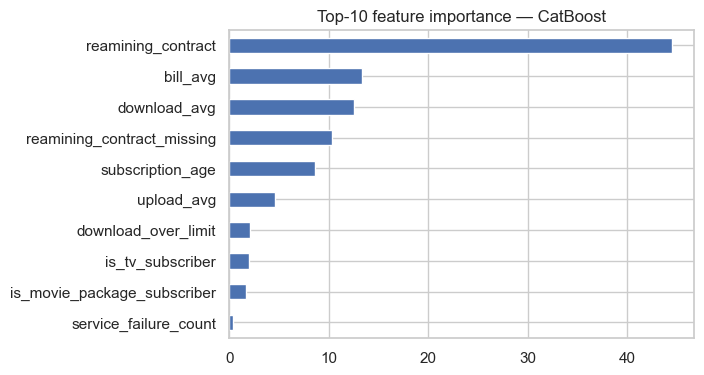

In [14]:
# 14. Візуалізація важливості ознак (для моделей, які її підтримують)
tree_models = ['RandomForest','GradientBoosting','XGBoost','LightGBM','CatBoost']
for tm in tree_models:
    entry = next((r for r in results if r['model_name']==tm), None)
    if entry is None:
        continue
    model_obj = entry['model_obj']
    try:
        if hasattr(model_obj, 'feature_importances_'):
            fi = pd.Series(model_obj.feature_importances_, index=X_train.columns).sort_values(ascending=False)
            plt.figure(figsize=(6,4))
            fi.head(10).plot(kind='barh')
            plt.gca().invert_yaxis()
            plt.title(f'Top-10 feature importance — {tm}')
            plt.show()
    except Exception as e:
        print("Не вдалося показати importance для", tm, e)